Agent Evaluation for Customer Support: Comparing Models and Parameters
This notebook demonstrates how to generate synthetic evaluation data and compare different models and parameters for a customer support agent. We'll explore three main types of evaluations:
Final Response Evaluation: Assessing the agent's final answer
Single Step Evaluation: Evaluating individual tool selections
Trajectory Evaluation: Analyzing the complete path of actions

Setup
First, let's import the necessary libraries and initialize our environment:

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from rich.console import Console
from rich.table import Table
import weave
from typing import List, Dict, Any, Tuple
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Import our modules
from evaluator import AgentEvaluator, load_dataset
from dataset_generator import DatasetGenerator, create_customer_support_agent_evaluation_dataset
from customer_support_agent import create_customer_support_agent
from config import WEAVE_PROJECT_NAME

try:
    in_jupyter = True
except ImportError:
    in_jupyter = False
if in_jupyter:
    import nest_asyncio

    nest_asyncio.apply()

# Initialize console for rich output
console = Console()
console.rule("[bold magenta]Agent Evaluation Framework")

# Initialize Weave for experiment tracking
weave.init(WEAVE_PROJECT_NAME)

─────────────────────────────────────────── Agent Evaluation Framework ────────────────────────────────────────────

Logged in as Weights & Biases user: a-sh0ts.
View Weave data at https://wandb.ai/a-sh0ts/agent_evaluation/weave


In [2]:
# Define model configurations to test
model_configs = [
    {"model_id": "google/gemini-1.5-pro", "temperature": 0.2, "name": "Gemini Pro (Low Temp)"},
    {"model_id": "google/gemini-1.5-pro", "temperature": 0.7, "name": "Gemini Pro (High Temp)"},
    {"model_id": "google/gemini-2.0-flash-lite", "temperature": 0.2, "name": "Gemini Flash Lite (Low Temp)"},
    {"model_id": "google/gemini-2.0-flash-lite", "temperature": 0.7, "name": "Gemini Flash Lite (High Temp)"},
    #Add not deepseak but OSS model from vertex{}
]

Generate Synthetic Evaluation Dataset
Let's create a synthetic dataset for evaluating our customer support agents:

In [ ]:
console.print("[bold blue]Generating synthetic evaluation dataset...[/bold blue]")

# Create base customer support agent for dataset generation
base_agent = create_customer_support_agent(
    use_weave=True,
    model_id="google/gemini-2.0-flash",
    temperature=0.1,
    planning_interval=2,
    max_steps=4
)



In [ ]:
base_agent.run("What is the best item in the category of book?")

In [ ]:
# Initialize dataset generator
thresholds={
            "final_response": 0.7,
            "single_step": 0.7,
            "trajectory": 0.7
        }
generator = DatasetGenerator(agent=base_agent, thresholds=thresholds, debug=True)

# Generate comprehensive dataset with different scenarios
console.print("[bold blue]Generating customer support evaluation dataset...[/bold blue]")

dataset = create_customer_support_agent_evaluation_dataset(generator, base_agent, num_prompts=5)  # Adjust number as needed

# Save generated dataset
dataset_path = "customer_support_eval.json"
generator.save_dataset(dataset, dataset_path)

console.print(f"[green]✓[/green] Dataset generation complete! Saved to {dataset_path}")

Initialize the Evaluator
Now let's set up our evaluation framework:

In [3]:
# Initialize evaluator
console.print("[bold blue]Initializing evaluator...[/bold blue]")
evaluator = AgentEvaluator(verbosity=1, project=os.getenv("VERTEX_PROJECT_ID"), location=os.getenv("VERTEX_LOCATION"))
console.print(f"[green]✓[/green] Evaluator initialized")

all_examples = load_dataset("customer_support_eval.json")
console.print(f"[bold blue]Formatting dataset with {len(all_examples)} examples for evaluation...[/bold blue]")
eval_dataset = evaluator.format_dataset_for_eval(all_examples)
console.print(f"[green]✓[/green] Dataset formatted successfully")

Initializing evaluator...

✓ Evaluator initialized

Formatting dataset with 4 examples for evaluation...

✓ Dataset formatted successfully

Run Evaluations for Different Model Configurations
Now let's evaluate different model configurations:

Evaluating Gemini Pro (Low Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/4

Prompt: I'm looking for products in the beauty category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the beauty category. What do you have?                                              │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  products = category_browse(category="beauty")                                                                    
  print(products)                                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "beauty",
  "product_count": 9,
  "price_range": "$29.72 - $97.17",
  "top_products": [
    {
      "product_id": "product_en_0043947",
      "name": "Beauty Item 3947",
      "price": "$97.17",
      "stock": 142
    },
    {
      "product_id": "product_en_0016651",
      "name": "Beauty Item 6651",
      "price": "$70.35",
      "stock": 143
    },
    {
      "product_id": "product_en_0040280",
      "name": "Beauty Item 0280",
      "price": "$64.70",
      "stock": 78
    },
    {
      "product_id": "product_en_0025328",
      "name": "Beauty Item 5328",
      "price": "$58.74",
      "stock": 86
    },
    {
      "product_id": "product_en_0003330",
      "name": "Beauty Item 3330",
      "price": "$50.60",
      "stock": 165
    }
  ]
}

Out: None

[Step 1: Duration 1.94 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f"We have 9 products in the beauty category, ranging in price from $29.72 to $97.17. Our top products      
  are:")                                                                                                           
  for product in products['top_products']:                                                                         
      print(f"- {product['name']}: ${product['price']}")                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
We have 9 products in the beauty category, ranging in price from $29.72 to $97.17. Our top products are:

Code execution failed at line 'for product in products['top_products'\]:
    print(f"- {product['name'\]}: ${product['price'\]}")' due to: InterpreterError: You're trying to subscript a 
string with a string index, which is impossible

[Step 2: Duration 4.63 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("I can show you a list of products in the beauty category. What are you looking for specifically?")        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
I can show you a list of products in the beauty category. What are you looking for specifically?

Out: None

[Step 3: Duration 3.07 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Wait for user response                                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 4: Duration 1.61 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Wait for user response                                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 5: Duration 2.20 seconds]

Reached max steps.

[Step 6: Duration 3.55 seconds]

Example 2/4

Prompt: Can you check the status of my order OD758843?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD758843?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(order_status(order_id='OD758843'))                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD758843",
  "customer_id": "reviewer_en_0315252",
  "product_id": "product_en_0914391",
  "status": "delivered",
  "order_date": "2024-11-22",
  "delivery_date": "2024-11-23",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK98966276",
  "tracking_info": {
    "number": "TRK98966276",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK98966276"
  }
}

Out: None

[Step 1: Duration 1.62 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Your order OD758843 has been delivered.")                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Your order OD758843 has been delivered.

[Step 2: Duration 1.74 seconds]

Example 3/4

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0167312

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0167312                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  recent_orders = customer_order_history(customer_id='reviewer_en_0167312')                                        
  print(recent_orders)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0167312",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD483215",
      "date": "2024-09-12",
      "status": "processing",
      "product_id": "product_en_0074366"
    }
  ]
}

Out: None

[Step 1: Duration 1.93 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f"You have {recent_orders['order_count']} recent order:")                                                  
  for order in recent_orders['recent_orders']:                                                                     
      print(f"Order ID: {order['order_id']}")                                                                      
      print(f"Date: {order['date']}")                                                                              
      print(f"Status: {order['status']}")                                                                          
      print(f"Product ID: {order['product_id']}")                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f"You have {recent_orders['order_count'\]} recent order:")' due to: 
InterpreterError: You're trying to subscript a string with a string index, which is impossible

[Step 2: Duration 5.60 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
  recent_orders = json.loads(recent_orders)                                                                        
                                                                                                                   
  print(f"You have {recent_orders['order_count']} recent order:")                                                  
  for order in recent_orders['recent_orders']:                                                                     
      print(f"Order ID: {order['order_id']}")                                                                      
      print(f"Date: {order['date']}")                                                                              
      print(f"Status: {order['status']}")                                                                          
      print(f"Product ID: {order['product_id']}")                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
You have 1 recent order:
Order ID: OD483215
Date: 2024-09-12
Status: processing
Product ID: product_en_0074366

Out: None

[Step 3: Duration 6.60 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Recent orders displayed successfully.")                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Recent orders displayed successfully.

[Step 4: Duration 3.39 seconds]

Example 4/4

Prompt: I'm looking for drugstore products and also want to check my order OD168581

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for drugstore products and also want to check my order OD168581                                     │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  drugstore_products = category_browse(category="Drugstore")                                                       
  print(drugstore_products)                                                                                        
                                                                                                                   
  order_status = order_status(order_id="OD168581")                                                                 
  print(f"The status of order OD168581 is: {order_status}")                                                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "drugstore",
  "product_count": 5,
  "price_range": "$36.32 - $69.32",
  "top_products": [
    {
      "product_id": "product_en_0011454",
      "name": "Drugstore Item 1454",
      "price": "$69.32",
      "stock": 178
    },
    {
      "product_id": "product_en_0103505",
      "name": "Drugstore Item 3505",
      "price": "$64.25",
      "stock": 77
    },
    {
      "product_id": "product_en_0041279",
      "name": "Drugstore Item 1279",
      "price": "$55.16",
      "stock": 107
    },
    {
      "product_id": "product_en_0006520",
      "name": "Drugstore Item 6520",
      "price": "$42.95",
      "stock": 108
    },
    {
      "product_id": "product_en_0002657",
      "name": "Drugstore Item 2657",
      "price": "$36.32",
      "stock": 51
    }
  ]
}

Code execution failed at line 'order_status = order_status(order_id="OD168581")' due to: InterpreterError: Cannot 
assign to name 'order_status': doing this would erase the existing tool!

[Step 1: Duration 2.84 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  order_status_result = order_status(order_id="OD168581")                                                          
  print(f"The status of order OD168581 is: {order_status_result}")                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
The status of order OD168581 is: {
  "order_id": "OD168581",
  "customer_id": "reviewer_en_0853133",
  "product_id": "product_en_0003501",
  "status": "delivered",
  "order_date": "2025-01-01",
  "delivery_date": "2025-01-02",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK95456596",
  "product_name": "Toy Item 3501",
  "product_category": "toy",
  "product_price": "$45.12",
  "tracking_info": {
    "number": "TRK95456596",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK95456596"
  }
}

Out: None

[Step 2: Duration 2.41 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("Do you need anything else?")                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Do you need anything else?

Out: None

[Step 3: Duration 1.59 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # I am waiting for your input.                                                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 4: Duration 1.23 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Awaiting further instructions.                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 5: Duration 2.25 seconds]

Reached max steps.

[Step 6: Duration 8.16 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741336161-0f637e11

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741336161-0f637e11 to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 4 responses from Gemini model gemini-1.5-pro.


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

All 4 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 4.997189957997762 seconds.
Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

All 20 metric requests are successfully computed.
Evaluation Took:20.0700694170082 seconds


✓ Saved detailed metrics to evaluation_results/gemini_pro_(low_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 2.00 │ 2.00   │ 1.00 │ 3.00 │
│ Reasoning Quality/Score       │ 2.25 │ 1.50   │ 1.00 │ 5.00 │
│ Response Correctness/Score    │ 3.75 │ 4.50   │ 1.00 │ 5.00 │
│ Trajectory Match/Score        │ 3.25 │ 3.00   │ 3.00 │ 4.00 │
│ Coherence/Score               │ 4.50 │ 4.50   │ 4.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 4.67            │ 1.33               │ 3.33               │ 2.00               │ 3.33              │
│ medium     │ 4.00            │ 5.00               │ 5.00               │ 2.00               │ 3.00              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Using 'model_output' key for compatibility with older scorers. Please update scorers to use 'output' parameter.


Evaluated 1 of 4 examples

Evaluated 2 of 4 examples

Evaluated 3 of 4 examples

Evaluated 4 of 4 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'coherence/score': {'mean': 4.5},
            'reasoning_quality/score': {'mean': 2.25},
            'trajectory_match/score': {'mean': 3.25},
            'response_correctness/score': {'mean': 3.75},
            'tool_selection_accuracy/score': {'mean': 2.0}
        }
    },
    'tool_selection_scorer': {'tool_selection': {'mean': 2.0}, 'tools_used': {'mean': 4.0}},
    'response_correctness_scorer': {'response_length': {'mean': 271.75}, 'response_correctness': {'mean': 0.0}},
    'trajectory_analysis_scorer': {
        'trajectory_match': {'mean': 0.0},
        'tools_in_trajectory': {'mean': 4.0},
        'trajectory_steps': {'mean': 4.0}
    },
    'model_latency': {'mean': 0.013035953044891357}
}

✓ Weave evaluation complete

Results for Gemini Pro (Low Temp):

                    Summary Metrics                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Coherence               │ 4.50  │ Excellent         │
│ Reasoning Quality       │ 2.25  │ Needs Improvement │
│ Response Correctness    │ 3.75  │ Good              │
│ Tool Selection Accuracy │ 2.00  │ Needs Improvement │
│ Trajectory Match        │ 3.25  │ Satisfactory      │
│ Row Count               │ 4.00  │                   │
└─────────────────────────┴───────┴───────────────────┘

Evaluating Gemini Pro (High Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/4

Prompt: I'm looking for products in the beauty category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the beauty category. What do you have?                                              │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  products = category_browse(category="beauty")                                                                    
  print(products)                                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "beauty",
  "product_count": 9,
  "price_range": "$29.72 - $97.17",
  "top_products": [
    {
      "product_id": "product_en_0043947",
      "name": "Beauty Item 3947",
      "price": "$97.17",
      "stock": 142
    },
    {
      "product_id": "product_en_0016651",
      "name": "Beauty Item 6651",
      "price": "$70.35",
      "stock": 143
    },
    {
      "product_id": "product_en_0040280",
      "name": "Beauty Item 0280",
      "price": "$64.70",
      "stock": 78
    },
    {
      "product_id": "product_en_0025328",
      "name": "Beauty Item 5328",
      "price": "$58.74",
      "stock": 86
    },
    {
      "product_id": "product_en_0003330",
      "name": "Beauty Item 3330",
      "price": "$50.60",
      "stock": 165
    }
  ]
}

Out: None

[Step 1: Duration 1.78 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f"There are {products['product_count']} products in the beauty category, ranging in price from             
  {products['price_range']}.")                                                                                     
  print("Here are the top 5 products:")                                                                            
  for product in products['top_products']:                                                                         
      print(f"- {product['name']} ({product['price']})")                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f"There are {products['product_count'\]} products in the beauty category, 
ranging in price from {products['price_range'\]}.")' due to: InterpreterError: You're trying to subscript a string 
with a string index, which is impossible

[Step 2: Duration 5.02 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
  products = json.loads(products)                                                                                  
  print(f"There are {products['product_count']} products in the beauty category, ranging in price from             
  {products['price_range']}.")                                                                                     
  print("Here are the top 5 products:")                                                                            
  for product in products['top_products']:                                                                         
      print(f"- {product['name']} ({product['price']})")                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
There are 9 products in the beauty category, ranging in price from $29.72 - $97.17.
Here are the top 5 products:
- Beauty Item 3947 ($97.17)
- Beauty Item 6651 ($70.35)
- Beauty Item 0280 ($64.70)
- Beauty Item 5328 ($58.74)
- Beauty Item 3330 ($50.60)

Out: None

[Step 3: Duration 5.47 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("I have listed the available information regarding products in the beauty category. Please let me   
  know if you have any other questions.")                                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: I have listed the available information regarding products in the beauty category. Please let 
me know if you have any other questions.

[Step 4: Duration 3.14 seconds]

Example 2/4

Prompt: Can you check the status of my order OD758843?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD758843?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(order_status(order_id='OD758843'))                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD758843",
  "customer_id": "reviewer_en_0315252",
  "product_id": "product_en_0914391",
  "status": "delivered",
  "order_date": "2024-11-22",
  "delivery_date": "2024-11-23",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK98966276",
  "tracking_info": {
    "number": "TRK98966276",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK98966276"
  }
}

Out: None

[Step 1: Duration 1.62 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Your order OD758843 has been delivered.")                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Your order OD758843 has been delivered.

[Step 2: Duration 1.69 seconds]

Example 3/4

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0167312

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0167312                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  recent_orders = customer_order_history(customer_id='reviewer_en_0167312')                                        
  print(recent_orders)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0167312",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD483215",
      "date": "2024-09-12",
      "status": "processing",
      "product_id": "product_en_0074366"
    }
  ]
}

Out: None

[Step 1: Duration 1.90 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f'You have {recent_orders["order_count"]} recent order:\n')                                                
  print(f'Order ID: {recent_orders["recent_orders"][0]["order_id"]}')                                              
  print(f'Date: {recent_orders["recent_orders"][0]["date"]}')                                                      
  print(f'Status: {recent_orders["recent_orders"][0]["status"]}')                                                  
  print(f'Product ID: {recent_orders["recent_orders"][0]["product_id"]}')                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f'You have {recent_orders["order_count"\]} recent order:\n')' due to: 
InterpreterError: You're trying to subscript a string with a string index, which is impossible

[Step 2: Duration 3.39 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f'You have {recent_orders["order_count"]} recent order:\n')                                                
  print(f'Order ID: {recent_orders["recent_orders"][0]["order_id"]}')                                              
  print(f'Date: {recent_orders["recent_orders"][0]["date"]}')                                                      
  print(f'Status: {recent_orders["recent_orders"][0]["status"]}')                                                  
  print(f'Product ID: {recent_orders["recent_orders"][0]["product_id"]}')                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f'You have {recent_orders["order_count"\]} recent order:\n')' due to: 
InterpreterError: You're trying to subscript a string with a string index, which is impossible

[Step 3: Duration 6.19 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f"You have {recent_orders['order_count']} recent order(s):")                                               
  for order in recent_orders['recent_orders']:                                                                     
      print(f"  Order ID: {order['order_id']}")                                                                    
      print(f"  Date: {order['date']}")                                                                            
      print(f"  Status: {order['status']}")                                                                        
      print(f"  Product ID: {order['product_id']}")                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f"You have {recent_orders['order_count'\]} recent order(s):")' due to: 
InterpreterError: You're trying to subscript a string with a string index, which is impossible

[Step 4: Duration 6.00 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
  recent_orders = json.loads(recent_orders)                                                                        
                                                                                                                   
  print(f"You have {recent_orders['order_count']} recent order(s):")                                               
  for order in recent_orders['recent_orders']:                                                                     
      print(f"  Order ID: {order['order_id']}")                                                                    
      print(f"  Date: {order['date']}")                                                                            
      print(f"  Status: {order['status']}")                                                                        
      print(f"  Product ID: {order['product_id']}")                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
You have 1 recent order(s):
  Order ID: OD483215
  Date: 2024-09-12
  Status: processing
  Product ID: product_en_0074366

Out: None

[Step 5: Duration 6.85 seconds]

Reached max steps.

[Step 6: Duration 8.59 seconds]

Example 4/4

Prompt: I'm looking for drugstore products and also want to check my order OD168581

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for drugstore products and also want to check my order OD168581                                     │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(category_browse(category="Drugstore"))                                                                     
  print(order_status(order_id="OD168581"))                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "drugstore",
  "product_count": 5,
  "price_range": "$36.32 - $69.32",
  "top_products": [
    {
      "product_id": "product_en_0011454",
      "name": "Drugstore Item 1454",
      "price": "$69.32",
      "stock": 178
    },
    {
      "product_id": "product_en_0103505",
      "name": "Drugstore Item 3505",
      "price": "$64.25",
      "stock": 77
    },
    {
      "product_id": "product_en_0041279",
      "name": "Drugstore Item 1279",
      "price": "$55.16",
      "stock": 107
    },
    {
      "product_id": "product_en_0006520",
      "name": "Drugstore Item 6520",
      "price": "$42.95",
      "stock": 108
    },
    {
      "product_id": "product_en_0002657",
      "name": "Drugstore Item 2657",
      "price": "$36.32",
      "stock": 51
    }
  ]
}
{
  "order_id": "OD168581",
  "customer_id": "reviewer_en_0853133",
  "product_id": "product_en_0003501",
  "status": "delivered",
  "order_date": "2025-01-01",
  "delivery_date": "2025-01-02",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK95456596",
  "product_name": "Toy Item 3501",
  "product_category": "toy",
  "product_price": "$45.12",
  "tracking_info": {
    "number": "TRK95456596",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK95456596"
  }
}

Out: None

[Step 1: Duration 2.25 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("Do you need any further assistance?")                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Do you need any further assistance?

Out: None

[Step 2: Duration 1.63 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("What else can I help you with today?")                                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
What else can I help you with today?

Out: None

[Step 3: Duration 2.59 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("I'm listening for your next question or instruction.")                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
I'm listening for your next question or instruction.

Out: None

[Step 4: Duration 2.33 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("Is there anything else I can assist you with?")                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Is there anything else I can assist you with?

Out: None

[Step 5: Duration 2.32 seconds]

Reached max steps.

[Step 6: Duration 6.44 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741336251-08a22307

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741336251-08a22307 to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 4 responses from Gemini model gemini-1.5-pro.


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

All 4 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 3.879424167011166 seconds.
Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 20/20 [00:20<00:00,  1.02s/it]

All 20 metric requests are successfully computed.
Evaluation Took:20.33791370797553 seconds


✓ Saved detailed metrics to evaluation_results/gemini_pro_(high_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 1.75 │ 2.00   │ 1.00 │ 2.00 │
│ Reasoning Quality/Score       │ 2.75 │ 2.50   │ 1.00 │ 5.00 │
│ Response Correctness/Score    │ 4.75 │ 5.00   │ 4.00 │ 5.00 │
│ Trajectory Match/Score        │ 3.25 │ 3.00   │ 3.00 │ 4.00 │
│ Coherence/Score               │ 4.50 │ 4.50   │ 4.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 4.67            │ 2.00               │ 4.67               │ 1.67               │ 3.33              │
│ medium     │ 4.00            │ 5.00               │ 5.00               │ 2.00               │ 3.00              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Evaluated 1 of 4 examples

Evaluated 2 of 4 examples

Evaluated 3 of 4 examples

Evaluated 4 of 4 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'coherence/score': {'mean': 4.5},
            'reasoning_quality/score': {'mean': 2.75},
            'trajectory_match/score': {'mean': 3.25},
            'response_correctness/score': {'mean': 4.75},
            'tool_selection_accuracy/score': {'mean': 1.75}
        }
    },
    'tool_selection_scorer': {'tool_selection': {'mean': 1.75}, 'tools_used': {'mean': 4.0}},
    'response_correctness_scorer': {'response_length': {'mean': 205.25}, 'response_correctness': {'mean': 0.0}},
    'trajectory_analysis_scorer': {
        'trajectory_match': {'mean': 0.0},
        'tools_in_trajectory': {'mean': 4.0},
        'trajectory_steps': {'mean': 4.0}
    },
    'model_latency': {'mean': 0.007702529430389404}
}

✓ Weave evaluation complete

Results for Gemini Pro (High Temp):

                    Summary Metrics                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Coherence               │ 4.50  │ Excellent         │
│ Reasoning Quality       │ 2.75  │ Needs Improvement │
│ Response Correctness    │ 4.75  │ Excellent         │
│ Tool Selection Accuracy │ 1.75  │ Poor              │
│ Trajectory Match        │ 3.25  │ Satisfactory      │
│ Row Count               │ 4.00  │                   │
└─────────────────────────┴───────┴───────────────────┘

Evaluating Gemini Flash Lite (Low Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/4

Prompt: I'm looking for products in the beauty category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the beauty category. What do you have?                                              │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  products = category_browse(category="beauty")                                                                    
  print(products)                                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "beauty",
  "product_count": 9,
  "price_range": "$29.72 - $97.17",
  "top_products": [
    {
      "product_id": "product_en_0043947",
      "name": "Beauty Item 3947",
      "price": "$97.17",
      "stock": 142
    },
    {
      "product_id": "product_en_0016651",
      "name": "Beauty Item 6651",
      "price": "$70.35",
      "stock": 143
    },
    {
      "product_id": "product_en_0040280",
      "name": "Beauty Item 0280",
      "price": "$64.70",
      "stock": 78
    },
    {
      "product_id": "product_en_0025328",
      "name": "Beauty Item 5328",
      "price": "$58.74",
      "stock": 86
    },
    {
      "product_id": "product_en_0003330",
      "name": "Beauty Item 3330",
      "price": "$50.60",
      "stock": 165
    }
  ]
}

Out: None

[Step 1: Duration 1.49 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("I have a variety of beauty products, including Beauty Item 3947, Beauty Item 6651, Beauty Item     
  0280, Beauty Item 5328, and Beauty Item 3330. The prices range from $29.72 to $97.17.")                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: I have a variety of beauty products, including Beauty Item 3947, Beauty Item 6651, Beauty Item 
0280, Beauty Item 5328, and Beauty Item 3330. The prices range from $29.72 to $97.17.

[Step 2: Duration 1.01 seconds]

Example 2/4

Prompt: Can you check the status of my order OD758843?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD758843?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  order_status_result = order_status(order_id="OD758843")                                                          
  print(order_status_result)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD758843",
  "customer_id": "reviewer_en_0315252",
  "product_id": "product_en_0914391",
  "status": "delivered",
  "order_date": "2024-11-22",
  "delivery_date": "2024-11-23",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK98966276",
  "tracking_info": {
    "number": "TRK98966276",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK98966276"
  }
}

Out: None

[Step 1: Duration 1.07 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("The order OD758843 is delivered.")                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The order OD758843 is delivered.

[Step 2: Duration 0.61 seconds]

Example 3/4

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0167312

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0167312                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  customer_id = "reviewer_en_0167312"                                                                              
  order_history = customer_order_history(customer_id=customer_id)                                                  
  print(order_history)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0167312",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD483215",
      "date": "2024-09-12",
      "status": "processing",
      "product_id": "product_en_0074366"
    }
  ]
}

Out: None

[Step 1: Duration 0.90 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(order_history)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "customer_id": "reviewer_en_0167312",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD483215",
      "date": "2024-09-12",
      "status": "processing",
      "product_id": "product_en_0074366"
    }
  ]
}

[Step 2: Duration 0.69 seconds]

Example 4/4

Prompt: I'm looking for drugstore products and also want to check my order OD168581

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for drugstore products and also want to check my order OD168581                                     │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  drugstore_products = product_search(query="drugstore products")                                                  
  print(drugstore_products)                                                                                        
  order_status_result = order_status(order_id="OD168581")                                                          
  print(order_status_result)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{"error": "Product not found"}
{
  "order_id": "OD168581",
  "customer_id": "reviewer_en_0853133",
  "product_id": "product_en_0003501",
  "status": "delivered",
  "order_date": "2025-01-01",
  "delivery_date": "2025-01-02",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK95456596",
  "product_name": "Toy Item 3501",
  "product_category": "toy",
  "product_price": "$45.12",
  "tracking_info": {
    "number": "TRK95456596",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK95456596"
  }
}

Out: None

[Step 1: Duration 1.03 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(f"Order OD168581 status: {order_status_result}. Product search failed.")                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Order OD168581 status: {
  "order_id": "OD168581",
  "customer_id": "reviewer_en_0853133",
  "product_id": "product_en_0003501",
  "status": "delivered",
  "order_date": "2025-01-01",
  "delivery_date": "2025-01-02",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK95456596",
  "product_name": "Toy Item 3501",
  "product_category": "toy",
  "product_price": "$45.12",
  "tracking_info": {
    "number": "TRK95456596",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK95456596"
  }
}. Product search failed.

[Step 2: Duration 1.01 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741336287-f670c4f0

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741336287-f670c4f0 to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 4 responses from Gemini model gemini-1.5-pro.


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

All 4 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 3.804325625009369 seconds.
Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

All 20 metric requests are successfully computed.
Evaluation Took:20.1596859160054 seconds


✓ Saved detailed metrics to evaluation_results/gemini_flash_lite_(low_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 2.75 │ 3.00   │ 2.00 │ 3.00 │
│ Reasoning Quality/Score       │ 2.00 │ 2.00   │ 1.00 │ 3.00 │
│ Response Correctness/Score    │ 4.50 │ 4.50   │ 4.00 │ 5.00 │
│ Trajectory Match/Score        │ 3.75 │ 4.00   │ 3.00 │ 4.00 │
│ Coherence/Score               │ 4.50 │ 4.50   │ 4.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 4.67            │ 2.00               │ 4.67               │ 2.67               │ 4.00              │
│ medium     │ 4.00            │ 2.00               │ 4.00               │ 3.00               │ 3.00              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Evaluated 1 of 4 examples

Evaluated 2 of 4 examples

Evaluated 3 of 4 examples

Evaluated 4 of 4 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'coherence/score': {'mean': 4.5},
            'reasoning_quality/score': {'mean': 2.0},
            'trajectory_match/score': {'mean': 3.75},
            'response_correctness/score': {'mean': 4.5},
            'tool_selection_accuracy/score': {'mean': 2.75}
        }
    },
    'tool_selection_scorer': {'tool_selection': {'mean': 2.75}, 'tools_used': {'mean': 2.0}},
    'response_correctness_scorer': {'response_length': {'mean': 248.75}, 'response_correctness': {'mean': 0.0}},
    'trajectory_analysis_scorer': {
        'trajectory_match': {'mean': 0.0},
        'tools_in_trajectory': {'mean': 2.0},
        'trajectory_steps': {'mean': 2.0}
    },
    'model_latency': {'mean': 0.008034467697143555}
}

✓ Weave evaluation complete

Results for Gemini Flash Lite (Low Temp):

                    Summary Metrics                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Coherence               │ 4.50  │ Excellent         │
│ Reasoning Quality       │ 2.00  │ Needs Improvement │
│ Response Correctness    │ 4.50  │ Excellent         │
│ Tool Selection Accuracy │ 2.75  │ Needs Improvement │
│ Trajectory Match        │ 3.75  │ Good              │
│ Row Count               │ 4.00  │                   │
└─────────────────────────┴───────┴───────────────────┘

Evaluating Gemini Flash Lite (High Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/4

Prompt: I'm looking for products in the beauty category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the beauty category. What do you have?                                              │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  products = category_browse(category="beauty")                                                                    
  print(products)                                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "beauty",
  "product_count": 9,
  "price_range": "$29.72 - $97.17",
  "top_products": [
    {
      "product_id": "product_en_0043947",
      "name": "Beauty Item 3947",
      "price": "$97.17",
      "stock": 142
    },
    {
      "product_id": "product_en_0016651",
      "name": "Beauty Item 6651",
      "price": "$70.35",
      "stock": 143
    },
    {
      "product_id": "product_en_0040280",
      "name": "Beauty Item 0280",
      "price": "$64.70",
      "stock": 78
    },
    {
      "product_id": "product_en_0025328",
      "name": "Beauty Item 5328",
      "price": "$58.74",
      "stock": 86
    },
    {
      "product_id": "product_en_0003330",
      "name": "Beauty Item 3330",
      "price": "$50.60",
      "stock": 165
    }
  ]
}

Out: None

[Step 1: Duration 1.48 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("We have several beauty products, including Beauty Item 3947 ($97.17), Beauty Item 6651 ($70.35),   
  Beauty Item 0280 ($64.70), Beauty Item 5328 ($58.74), and Beauty Item 3330 ($50.60).")                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: We have several beauty products, including Beauty Item 3947 ($97.17), Beauty Item 6651 
($70.35), Beauty Item 0280 ($64.70), Beauty Item 5328 ($58.74), and Beauty Item 3330 ($50.60).

[Step 2: Duration 1.15 seconds]

Example 2/4

Prompt: Can you check the status of my order OD758843?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD758843?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  order_status_result = order_status(order_id="OD758843")                                                          
  print(order_status_result)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD758843",
  "customer_id": "reviewer_en_0315252",
  "product_id": "product_en_0914391",
  "status": "delivered",
  "order_date": "2024-11-22",
  "delivery_date": "2024-11-23",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK98966276",
  "tracking_info": {
    "number": "TRK98966276",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK98966276"
  }
}

Out: None

[Step 1: Duration 1.08 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("The order OD758843 is delivered.")                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The order OD758843 is delivered.

[Step 2: Duration 0.62 seconds]

Example 3/4

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0167312

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0167312                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  customer_id = "reviewer_en_0167312"                                                                              
  order_history = customer_order_history(customer_id=customer_id)                                                  
  print(order_history)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0167312",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD483215",
      "date": "2024-09-12",
      "status": "processing",
      "product_id": "product_en_0074366"
    }
  ]
}

Out: None

[Step 1: Duration 0.79 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(order_history)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "customer_id": "reviewer_en_0167312",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD483215",
      "date": "2024-09-12",
      "status": "processing",
      "product_id": "product_en_0074366"
    }
  ]
}

[Step 2: Duration 0.80 seconds]

Example 4/4

Prompt: I'm looking for drugstore products and also want to check my order OD168581

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for drugstore products and also want to check my order OD168581                                     │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  drugstore_products = product_search(query="drugstore products")                                                  
  print(drugstore_products)                                                                                        
  order_status_result = order_status(order_id="OD168581")                                                          
  print(order_status_result)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{"error": "Product not found"}
{
  "order_id": "OD168581",
  "customer_id": "reviewer_en_0853133",
  "product_id": "product_en_0003501",
  "status": "delivered",
  "order_date": "2025-01-01",
  "delivery_date": "2025-01-02",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK95456596",
  "product_name": "Toy Item 3501",
  "product_category": "toy",
  "product_price": "$45.12",
  "tracking_info": {
    "number": "TRK95456596",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK95456596"
  }
}

Out: None

[Step 1: Duration 1.76 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(order_status_result)                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "order_id": "OD168581",
  "customer_id": "reviewer_en_0853133",
  "product_id": "product_en_0003501",
  "status": "delivered",
  "order_date": "2025-01-01",
  "delivery_date": "2025-01-02",
  "estimated_delivery_date": NaN,
  "tracking_number": "TRK95456596",
  "product_name": "Toy Item 3501",
  "product_category": "toy",
  "product_price": "$45.12",
  "tracking_info": {
    "number": "TRK95456596",
    "carrier": "Olist Logistics",
    "tracking_url": "https://tracking.olist.com/TRK95456596"
  }
}

[Step 2: Duration 1.05 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741336323-4a0ed206

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741336323-4a0ed206 to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 4 responses from Gemini model gemini-1.5-pro.


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

All 4 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 3.793460792017868 seconds.
Computing metrics with a total of 20 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

All 20 metric requests are successfully computed.
Evaluation Took:20.011847584013594 seconds


✓ Saved detailed metrics to evaluation_results/gemini_flash_lite_(high_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 3.25 │ 3.50   │ 2.00 │ 4.00 │
│ Reasoning Quality/Score       │ 1.75 │ 1.50   │ 1.00 │ 3.00 │
│ Response Correctness/Score    │ 4.25 │ 4.50   │ 3.00 │ 5.00 │
│ Trajectory Match/Score        │ 3.50 │ 3.50   │ 3.00 │ 4.00 │
│ Coherence/Score               │ 4.75 │ 5.00   │ 4.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 5.00            │ 1.67               │ 4.67               │ 3.00               │ 3.67              │
│ medium     │ 4.00            │ 2.00               │ 3.00               │ 4.00               │ 3.00              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Evaluated 1 of 4 examples

Evaluated 2 of 4 examples

Evaluated 3 of 4 examples

Evaluated 4 of 4 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'coherence/score': {'mean': 4.75},
            'reasoning_quality/score': {'mean': 1.75},
            'trajectory_match/score': {'mean': 3.5},
            'response_correctness/score': {'mean': 4.25},
            'tool_selection_accuracy/score': {'mean': 3.25}
        }
    },
    'tool_selection_scorer': {'tool_selection': {'mean': 3.25}, 'tools_used': {'mean': 2.0}},
    'response_correctness_scorer': {'response_length': {'mean': 237.25}, 'response_correctness': {'mean': 0.0}},
    'trajectory_analysis_scorer': {
        'trajectory_match': {'mean': 0.0},
        'tools_in_trajectory': {'mean': 2.0},
        'trajectory_steps': {'mean': 2.0}
    },
    'model_latency': {'mean': 0.012831032276153564}
}

✓ Weave evaluation complete

Results for Gemini Flash Lite (High Temp):

                 Summary Metrics                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Coherence               │ 4.75  │ Excellent    │
│ Reasoning Quality       │ 1.75  │ Poor         │
│ Response Correctness    │ 4.25  │ Very Good    │
│ Tool Selection Accuracy │ 3.25  │ Satisfactory │
│ Trajectory Match        │ 3.50  │ Good         │
│ Row Count               │ 4.00  │              │
└─────────────────────────┴───────┴──────────────┘

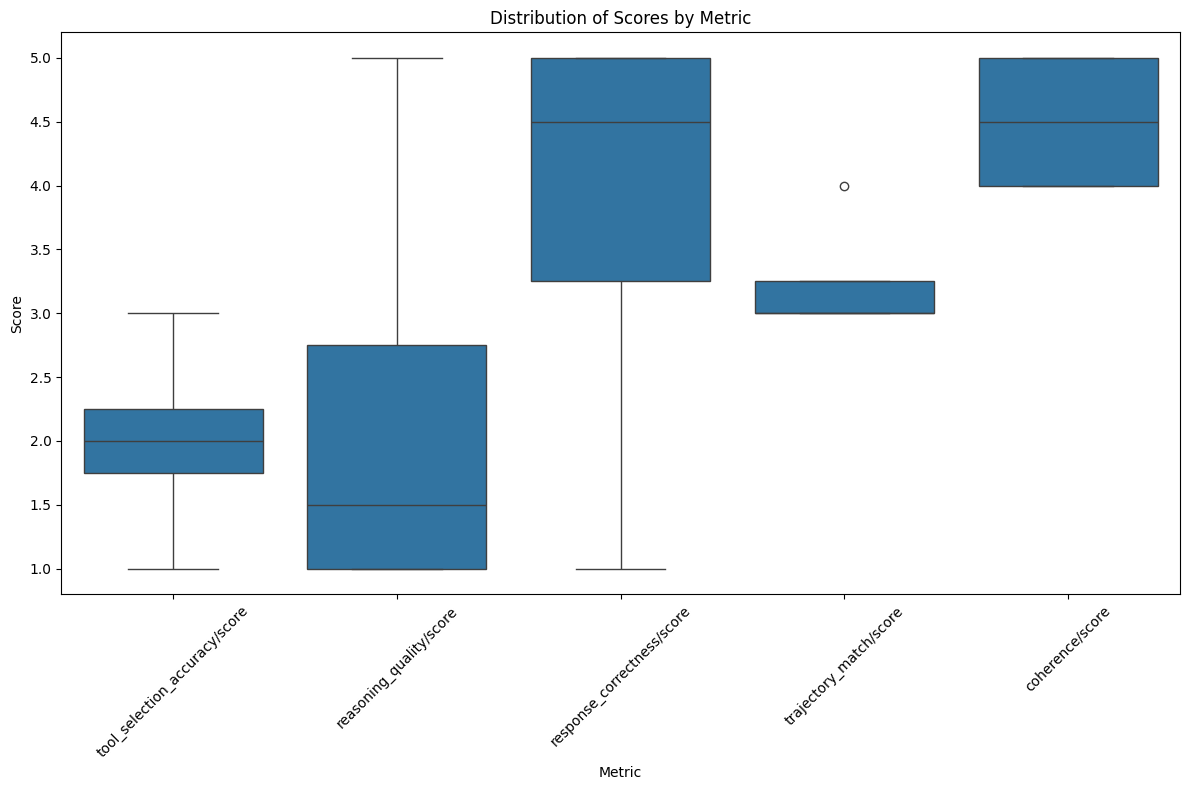

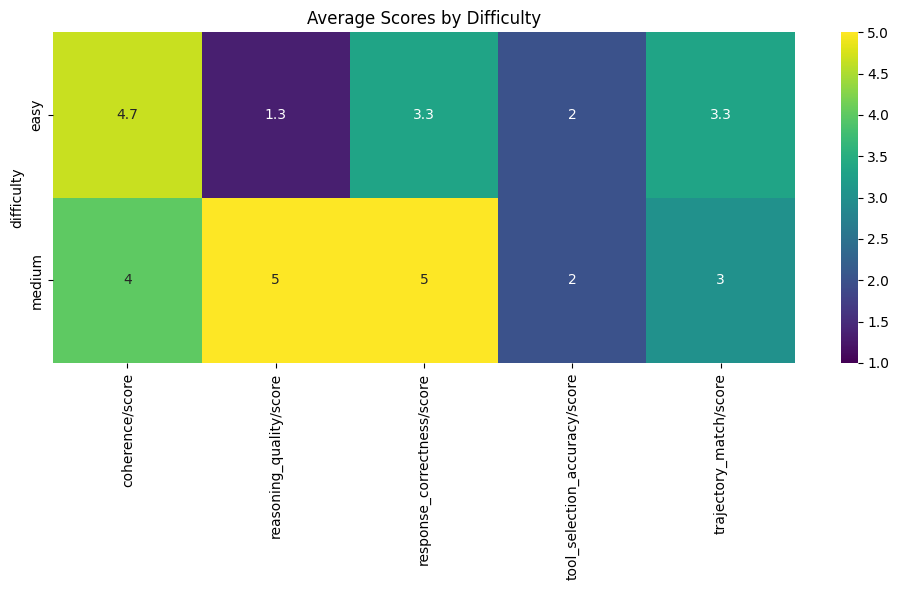

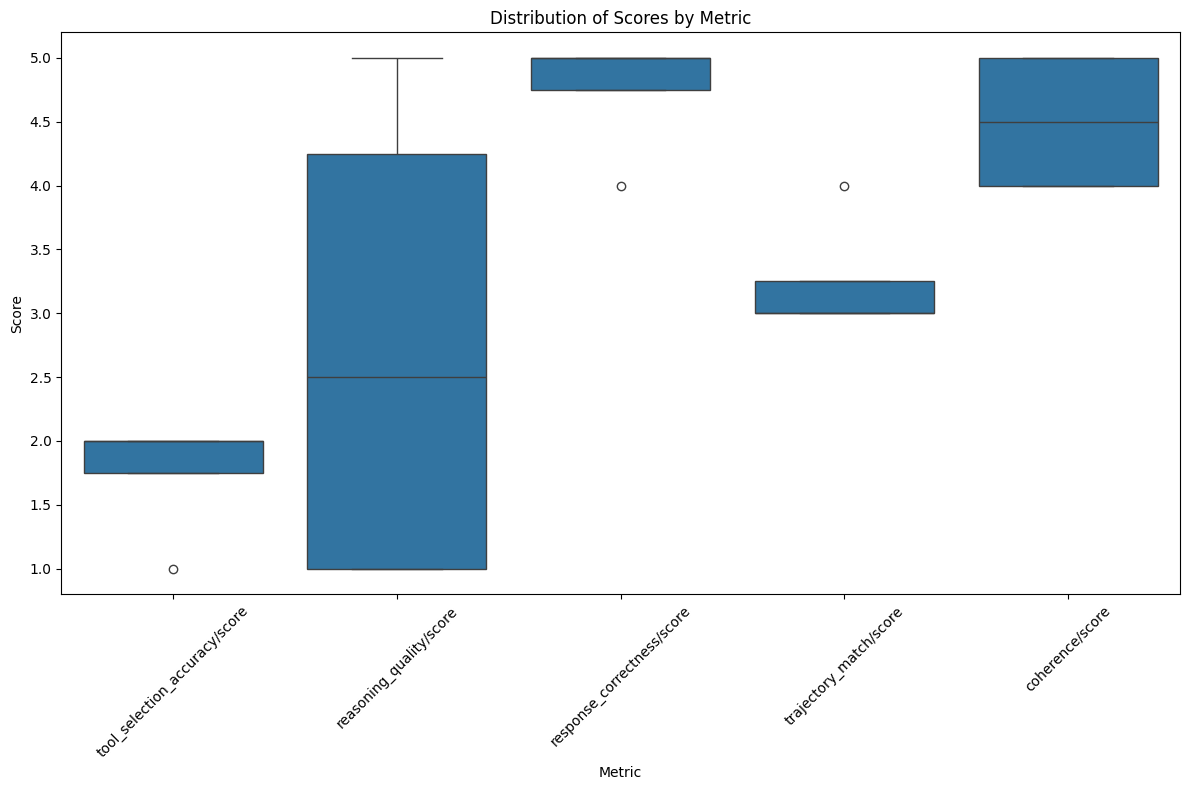

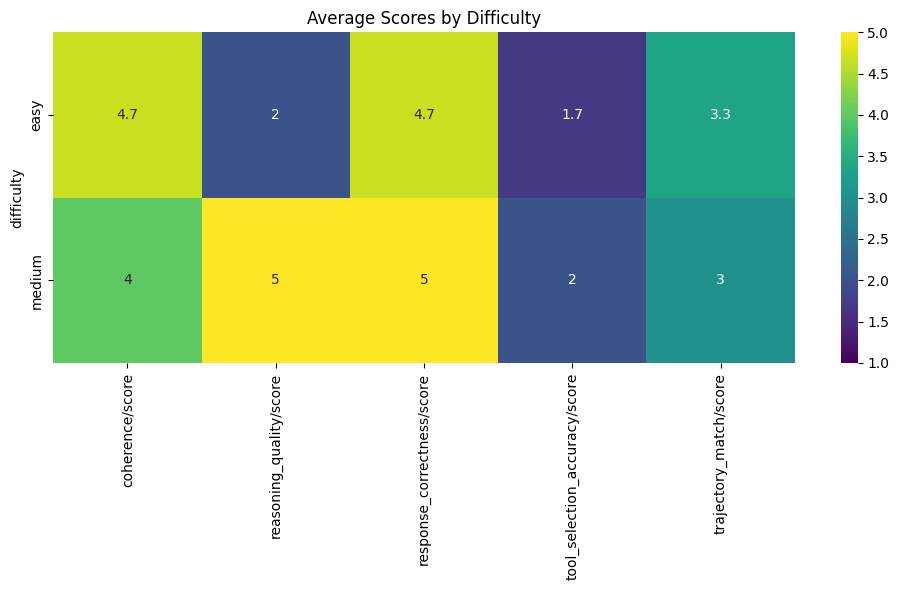

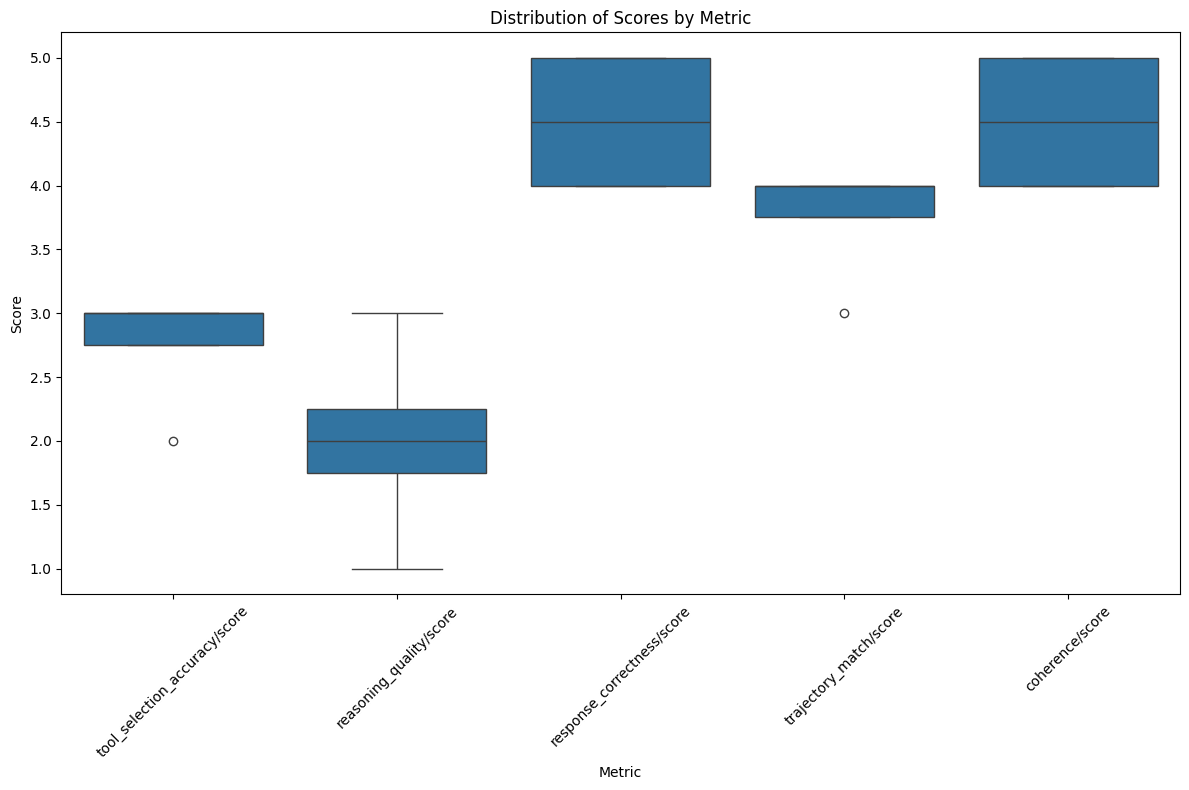

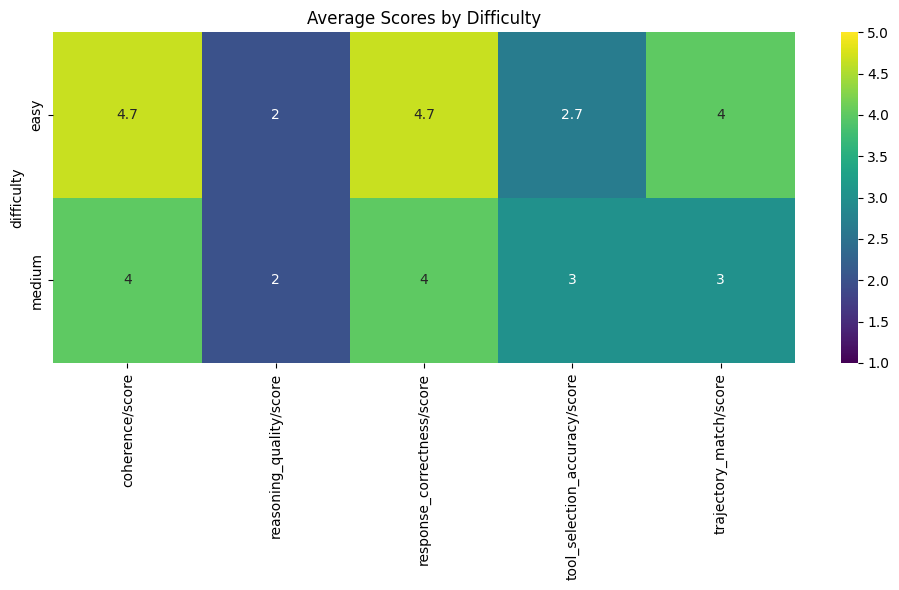

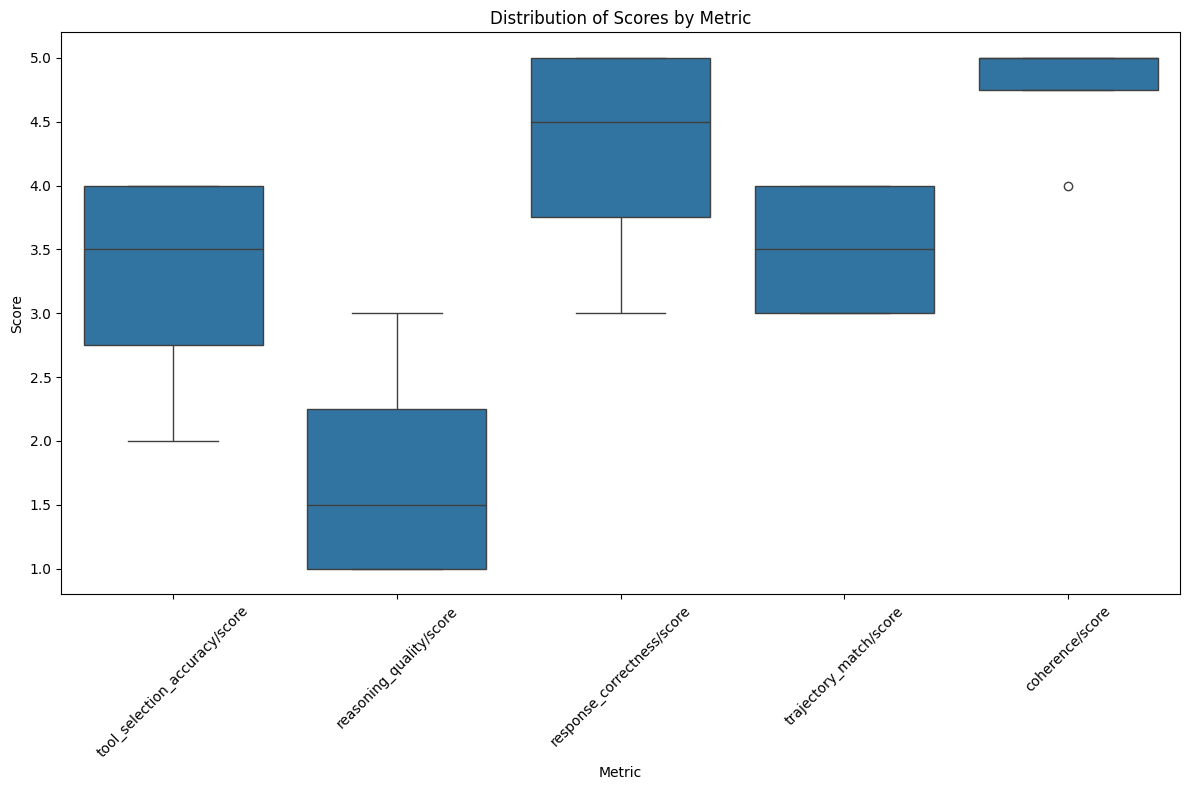

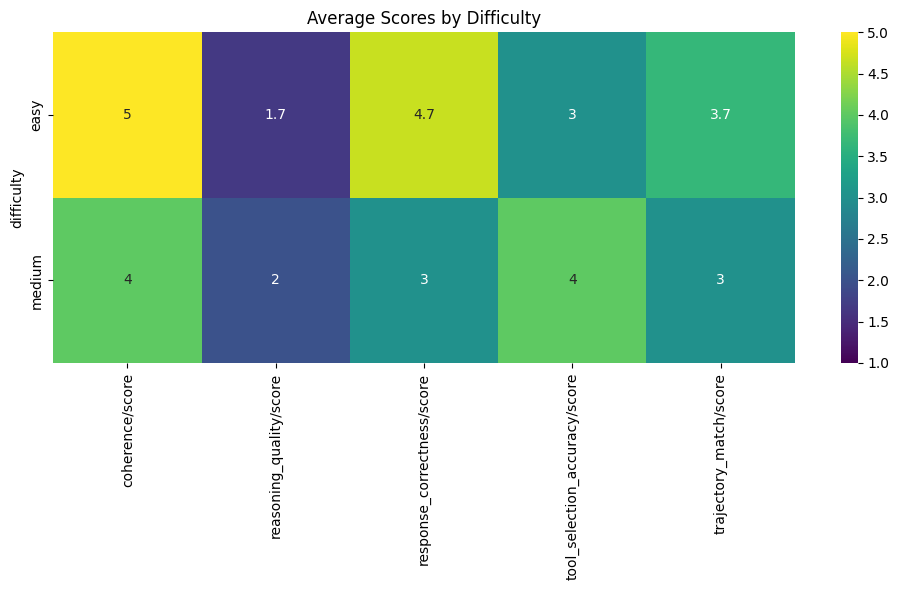

In [4]:
# ... existing code ...
@weave.op()
def evaluate_model_config(config: Dict[str, Any], eval_dataset: List[Dict[str, Any]]) -> Dict[str, Any]:
    """Evaluate a specific model configuration and return results"""
    console.print(f"\n[bold blue]Evaluating {config['name']}...[/bold blue]")
    
    # Create agent with this configuration
    agent = create_customer_support_agent(
        use_weave=True,
        model_id=config["model_id"],
        temperature=config["temperature"],
        planning_interval=config.get("planning_interval", 1),
        max_steps=config.get("max_steps", 5)
    )
    
    # Run evaluation with the agent object directly
    results = evaluator.run_evaluation(
        agent=agent, 
        eval_dataset=eval_dataset, 
        output_dir=f"evaluation_results/{config['name'].replace(' ', '_').lower()}",
        weave_project="agent_evaluation"
    )
    
    # Add configuration details to results
    results["config"] = config
    
    return results

# Run evaluations for all configurations
all_results = []
for config in model_configs:
    results = evaluate_model_config(config, eval_dataset)
    all_results.append(results)
    
    # Display summary results
    console.print(f"\n[bold green]Results for {config['name']}:[/bold green]")
    if "summary_metrics" in results and results["summary_metrics"]:
        table = evaluator._render_summary_table(results["summary_metrics"])
        console.print(table)
    else:
        console.print("[yellow]No summary metrics available[/yellow]")

Comparing Model Performance
Let's visualize and compare the performance of different model configurations in Weave:

Detailed Analysis of Model Differences
Let's analyze the differences between models in more detail:

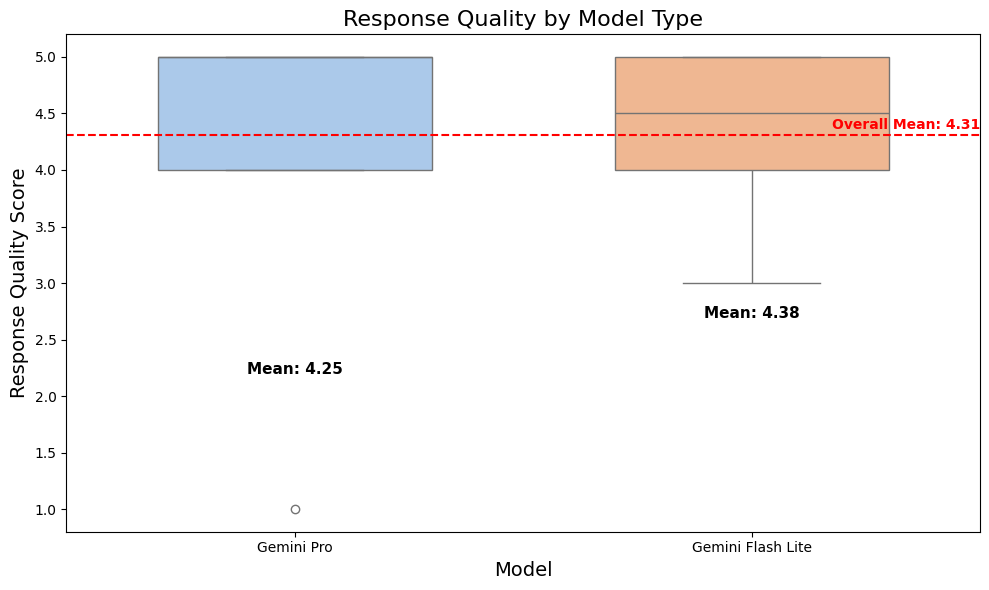

──────────────────────────────────────────── Model Performance Summary ────────────────────────────────────────────

                                             All Metrics by Model Type                                             
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                  ┃                 ┃ Reasoning        ┃ Response         ┃ Tool Selection    ┃ Trajectory       ┃
┃ Model            ┃ Coherence/Score ┃ Quality/Score    ┃ Correctness/Sco… ┃ Accuracy/Score    ┃ Match/Score      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Gemini Pro       │ 4.50            │ 2.50             │ 4.25             │ 1.88              │ 3.25             │
│ Gemini Flash     │ 4.62            │ 1.88             │ 4.38             │ 3.00              │ 3.62             │
│ Lite             │                 │                  │                  │                   │                  │
└──────────────────┴─────────────────┴──────────────────┴──────────────────┴───────────────────┴──────────────────┘

In [23]:
# Compare models and their impact on response quality
import numpy as np
import re

# Create a function to extract the base model name (ignoring parentheses)
def get_base_model_name(full_name):
    # Remove anything in parentheses and trim whitespace
    base_name = re.sub(r'\s*\([^)]*\)', '', full_name).strip()
    return base_name

# Prepare response data
response_data = []

for result in all_results:
    config = result["config"]
    detailed_metrics = result["detailed_metrics"]
    
    # Get base model name
    base_model = get_base_model_name(config["name"])
    
    # Find response quality column
    response_col = next((col for col in detailed_metrics.columns if "response" in col.lower() and "score" in col.lower()), None)
    
    if response_col and not detailed_metrics.empty:
        # Add model info to each row
        model_data = detailed_metrics.copy()
        model_data["Base Model"] = base_model
        model_data["Temperature"] = config["temperature"]
        
        # Select only needed columns
        model_data = model_data[["Base Model", "Temperature", response_col]].rename(columns={response_col: "Response Quality"})
        response_data.append(model_data)

# Combine all data
if response_data:
    combined_data = pd.concat(response_data, ignore_index=True)
    
    # Create a simple, clean figure
    plt.figure(figsize=(10, 6))
    
    # Create a basic boxplot
    ax = sns.boxplot(x="Base Model", y="Response Quality", data=combined_data, 
                    palette="pastel", width=0.6)
    
    # Simple, clean styling
    plt.title("Response Quality by Model Type", fontsize=16)
    plt.xlabel("Model", fontsize=14)
    plt.ylabel("Response Quality Score", fontsize=14)
    
    # Add the overall average line
    overall_mean = combined_data["Response Quality"].mean()
    plt.axhline(y=overall_mean, color='red', linestyle='--', linewidth=1.5)
    plt.text(len(combined_data["Base Model"].unique()) - 0.5, overall_mean + 0.05, 
             f"Overall Mean: {overall_mean:.2f}", 
             ha='right', color='red', fontweight='bold')
    
    # Add mean values as annotations - now below the boxes
    for i, model in enumerate(combined_data["Base Model"].unique()):
        model_data = combined_data[combined_data["Base Model"] == model]
        mean_score = model_data["Response Quality"].mean()
        
        # Calculate the bottom of the box
        q1 = model_data["Response Quality"].quantile(0.25)
        q3 = model_data["Response Quality"].quantile(0.75)
        iqr = q3 - q1
        bottom = max(model_data["Response Quality"].min(), q1 - 1.5 * iqr)
        
        # Place text below the box
        plt.text(i, bottom - 0.2, f"Mean: {mean_score:.2f}", 
                ha='center', va='top', fontweight='bold', fontsize=11)
    
    # Save and show
    plt.tight_layout()
    plt.savefig("model_response_quality.png", dpi=300)
    plt.show()
    
    # Create a comprehensive summary table with all metrics by model
    console.rule("[bold magenta]Model Performance Summary")
    
    # Get all metrics from all results
    all_metrics = {}
    for result in all_results:
        config = result["config"]
        metrics = result["summary_metrics"]
        base_model = get_base_model_name(config["name"])
        
        if base_model not in all_metrics:
            all_metrics[base_model] = {}
        
        # Add all mean metrics
        for metric_key, value in metrics.items():
            if "/Mean" in metric_key:
                # Clean up metric name for display
                clean_metric = metric_key.replace("/Mean", "").replace("_score", "").replace("_", " ").title()
                
                if clean_metric not in all_metrics[base_model]:
                    all_metrics[base_model][clean_metric] = []
                
                all_metrics[base_model][clean_metric].append(value)
    
    # Create a table with all metrics
    summary_table = Table(title="All Metrics by Model Type")
    
    # Add model column
    summary_table.add_column("Model", style="cyan")
    
    # Find all unique metrics
    all_metric_names = set()
    for model_metrics in all_metrics.values():
        all_metric_names.update(model_metrics.keys())
    
    # Add columns for each metric
    for metric in sorted(all_metric_names):
        summary_table.add_column(metric, style="green")
    
    # Add rows for each model
    for model, metrics in all_metrics.items():
        row_values = [model]
        
        for metric in sorted(all_metric_names):
            if metric in metrics:
                # Calculate average if there are multiple values (from different temperatures)
                avg_value = sum(metrics[metric]) / len(metrics[metric])
                row_values.append(f"{avg_value:.2f}")
            else:
                row_values.append("N/A")
        
        summary_table.add_row(*row_values)
    
    console.print(summary_table)
else:
    console.print("[yellow]Warning: No response quality data available for visualization[/yellow]")

Case Study: Comparing Models on a Specific Example
Let's examine one specific example to see how different models handle it:

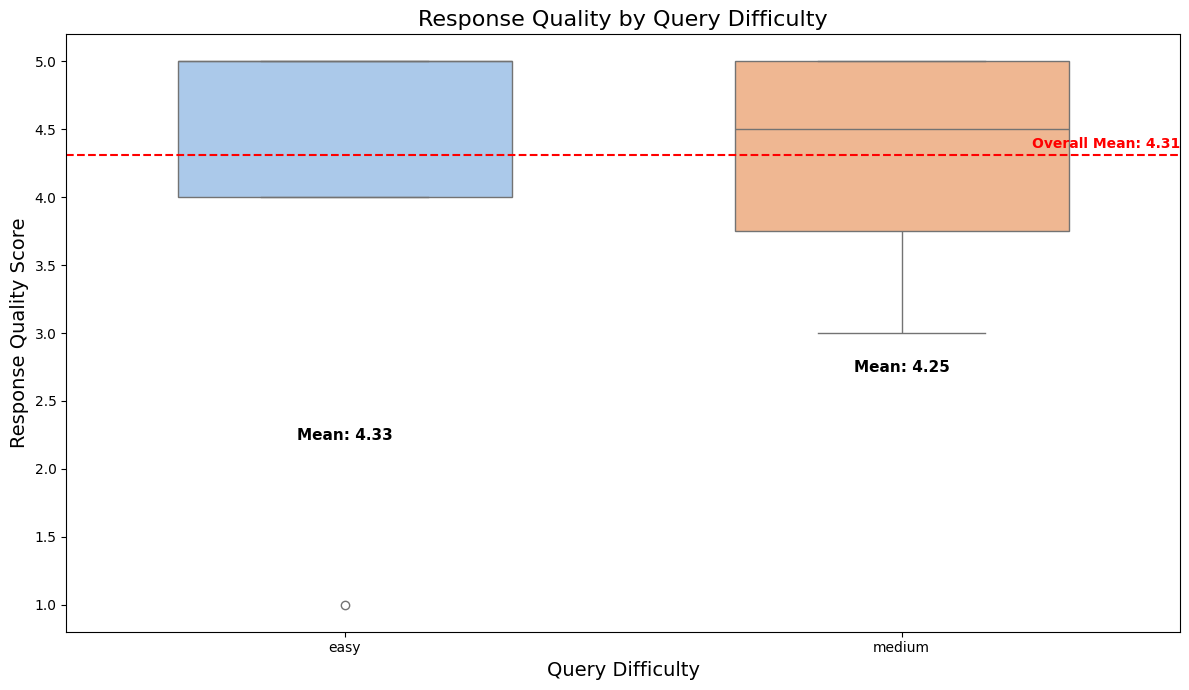

───────────────────────────────────── Best Model Configuration by Difficulty ──────────────────────────────────────

              Best Model Configuration for Each Difficulty Level               
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Difficulty ┃ Best Model        ┃ Temperature ┃ Score ┃ Improvement Over Avg ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ easy       │ Gemini Flash Lite │ 0.2         │ 4.67  │ +0.33 (7.7%)         │
│ medium     │ Gemini Pro        │ 0.2         │ 5.00  │ +0.75 (17.6%)        │
└────────────┴───────────────────┴─────────────┴───────┴──────────────────────┘

──────────────────────────────────────────── All Metrics by Difficulty ────────────────────────────────────────────

                                          All Metrics by Difficulty Level                                          
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 4.75            │ 1.75               │ 4.33               │ 2.33               │ 3.58              │
│ medium     │ 4.00            │ 3.50               │ 4.25               │ 2.75               │ 3.00              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

In [26]:
# Analyze performance by query difficulty
import numpy as np
import re

# Create a function to extract the base model name (ignoring parentheses)
def get_base_model_name(full_name):
    # Remove anything in parentheses and trim whitespace
    base_name = re.sub(r'\s*\([^)]*\)', '', full_name).strip()
    return base_name

# Create a dataframe with all detailed metrics and model info
all_detailed_metrics = []

for result in all_results:
    config = result["config"]
    detailed_metrics = result["detailed_metrics"].copy()
    
    # Skip if detailed_metrics is empty
    if detailed_metrics.empty:
        continue
    
    # Get base model name and temperature
    base_model = get_base_model_name(config["name"])
    temperature = config["temperature"]
    
    # Add model info to detailed metrics
    detailed_metrics["Base Model"] = base_model
    detailed_metrics["Temperature"] = temperature
    detailed_metrics["Model Config"] = f"{base_model} (T={temperature})"
    
    all_detailed_metrics.append(detailed_metrics)

# Only proceed if we have data
if all_detailed_metrics:
    all_metrics_df = pd.concat(all_detailed_metrics, ignore_index=True)
    
    # Check if difficulty column exists
    difficulty_col = next((col for col in all_metrics_df.columns if col.lower() == "difficulty"), None)
    
    # Find response correctness column
    response_col = next((col for col in all_metrics_df.columns if "response" in col.lower() and "score" in col.lower()), None)
    
    if difficulty_col and response_col:
        # Convert difficulty to string to ensure proper categorical plotting
        all_metrics_df[difficulty_col] = all_metrics_df[difficulty_col].astype(str)
        
        # Create a simple, clean figure
        plt.figure(figsize=(12, 7))
        
        # Plot performance by difficulty
        ax = sns.boxplot(x=difficulty_col, y=response_col, data=all_metrics_df, 
                        palette="pastel", width=0.6)
        
        # Simple, clean styling
        plt.title("Response Quality by Query Difficulty", fontsize=16)
        plt.xlabel("Query Difficulty", fontsize=14)
        plt.ylabel("Response Quality Score", fontsize=14)
        
        # Add the overall average line
        overall_mean = all_metrics_df[response_col].mean()
        plt.axhline(y=overall_mean, color='red', linestyle='--', linewidth=1.5)
        plt.text(len(all_metrics_df[difficulty_col].unique()) - 0.5, overall_mean + 0.05, 
                f"Overall Mean: {overall_mean:.2f}", 
                ha='right', color='red', fontweight='bold')
        
        # Add mean values as annotations below the boxes
        for i, difficulty in enumerate(sorted(all_metrics_df[difficulty_col].unique())):
            difficulty_data = all_metrics_df[all_metrics_df[difficulty_col] == difficulty]
            mean_score = difficulty_data[response_col].mean()
            
            # Calculate the bottom of the box
            q1 = difficulty_data[response_col].quantile(0.25)
            q3 = difficulty_data[response_col].quantile(0.75)
            iqr = q3 - q1
            bottom = max(difficulty_data[response_col].min(), q1 - 1.5 * iqr)
            
            # Place text below the box
            plt.text(i, bottom - 0.2, f"Mean: {mean_score:.2f}", 
                    ha='center', va='top', fontweight='bold', fontsize=11)
        
        # Save and show
        plt.tight_layout()
        plt.savefig("response_quality_by_difficulty.png", dpi=300)
        plt.show()
        
        # Create a detailed table showing best model for each difficulty level
        console.rule("[bold magenta]Best Model Configuration by Difficulty")
        
        detailed_table = Table(title="Best Model Configuration for Each Difficulty Level")
        detailed_table.add_column("Difficulty", style="cyan")
        detailed_table.add_column("Best Model", style="green")
        detailed_table.add_column("Temperature", style="yellow")
        detailed_table.add_column("Score", style="magenta")
        detailed_table.add_column("Improvement Over Avg", style="blue")
        
        # Add rows for each difficulty level
        for difficulty in sorted(all_metrics_df[difficulty_col].unique()):
            difficulty_data = all_metrics_df[all_metrics_df[difficulty_col] == difficulty]
            avg_score = difficulty_data[response_col].mean()
            
            # Group by model and temperature to find the best configuration
            grouped = difficulty_data.groupby(["Base Model", "Temperature"])[response_col].mean().reset_index()
            best_idx = grouped[response_col].idxmax()
            best_model = grouped.loc[best_idx, "Base Model"]
            best_temp = grouped.loc[best_idx, "Temperature"]
            best_score = grouped.loc[best_idx, response_col]
            
            # Calculate improvement over average
            improvement = best_score - avg_score
            improvement_pct = (improvement / avg_score) * 100 if avg_score > 0 else 0
            
            detailed_table.add_row(
                difficulty,
                best_model,
                f"{best_temp}",
                f"{best_score:.2f}",
                f"+{improvement:.2f} ({improvement_pct:.1f}%)"
            )
        
        console.print(detailed_table)
        
        # Create a table showing all metrics by difficulty
        console.rule("[bold magenta]All Metrics by Difficulty")
        
        # Find all score columns
        score_columns = [col for col in all_metrics_df.columns 
                        if "score" in col.lower() and col != response_col]
        
        # Add response column to the list if not already included
        if response_col and response_col not in score_columns:
            score_columns.append(response_col)
        
        # Create the table
        metrics_by_difficulty_table = Table(title="All Metrics by Difficulty Level")
        metrics_by_difficulty_table.add_column("Difficulty", style="cyan")
        
        # Add columns for each metric
        for col in sorted(score_columns):
            # Clean up column name for display
            clean_name = col.replace("_score", "").replace("_", " ").title()
            metrics_by_difficulty_table.add_column(clean_name, style="green")
        
        # Add rows for each difficulty level
        for difficulty in sorted(all_metrics_df[difficulty_col].unique()):
            difficulty_data = all_metrics_df[all_metrics_df[difficulty_col] == difficulty]
            
            row_values = [difficulty]
            
            for col in sorted(score_columns):
                if col in difficulty_data.columns:
                    avg_score = difficulty_data[col].mean()
                    row_values.append(f"{avg_score:.2f}")
                else:
                    row_values.append("N/A")
            
            metrics_by_difficulty_table.add_row(*row_values)
        
        console.print(metrics_by_difficulty_table)
    else:
        console.print("[yellow]Warning: Missing difficulty or response correctness columns in metrics data[/yellow]")
else:
    console.print("[yellow]Warning: No detailed metrics available for difficulty analysis[/yellow]")

Analysis of Parameter Impact
Let's analyze how temperature affects model performance:

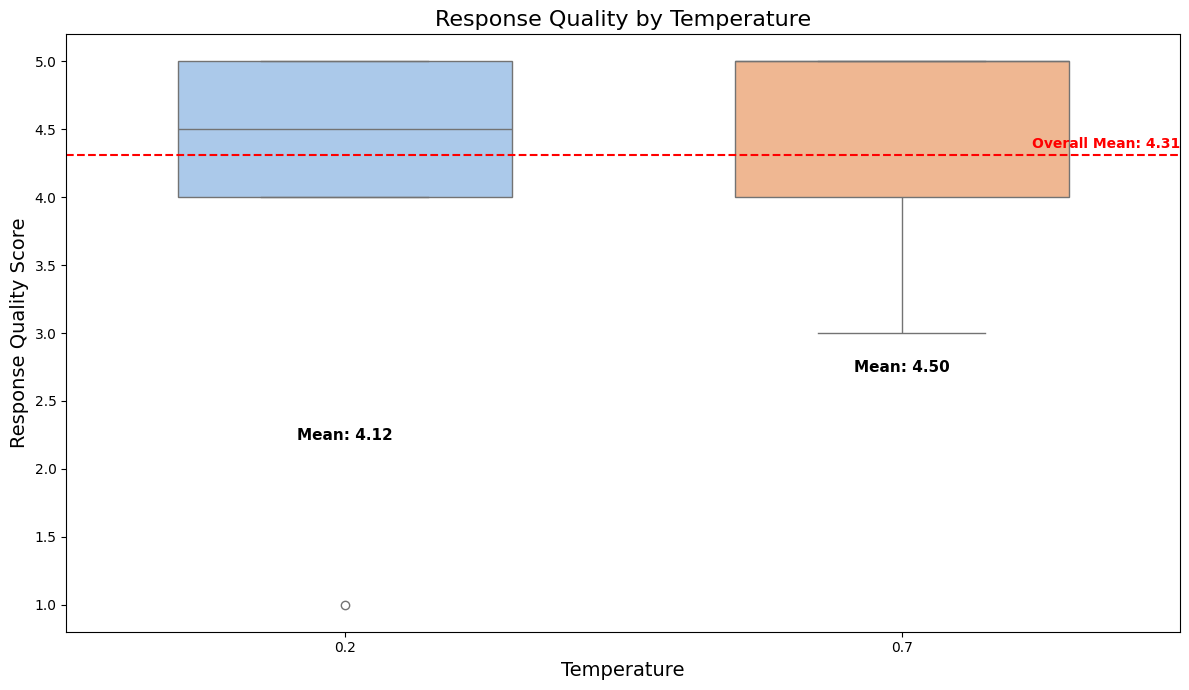

───────────────────────────────────── Best Model Configuration by Temperature ─────────────────────────────────────

          Best Model Configuration for Each Temperature           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Temperature ┃ Best Model        ┃ Score ┃ Improvement Over Avg ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.2         │ Gemini Flash Lite │ 4.50  │ +0.38 (9.1%)         │
│ 0.7         │ Gemini Pro        │ 4.75  │ +0.25 (5.6%)         │
└─────────────┴───────────────────┴───────┴──────────────────────┘

─────────────────────────────────────────── All Metrics by Temperature ────────────────────────────────────────────

                                            All Metrics by Temperature                                             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃             ┃                 ┃ Reasoning          ┃ Response          ┃ Tool Selection     ┃ Trajectory        ┃
┃ Temperature ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 0.2         │ 4.50            │ 2.12               │ 4.12              │ 2.38               │ 3.50              │
│ 0.7         │ 4.62            │ 2.25               │ 4.50              │ 2.50               │ 3.38              │
└─────────────┴─────────────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

In [27]:
# Analyze performance by temperature
import numpy as np
import re

# Create a function to extract the base model name (ignoring parentheses)
def get_base_model_name(full_name):
    # Remove anything in parentheses and trim whitespace
    base_name = re.sub(r'\s*\([^)]*\)', '', full_name).strip()
    return base_name

# Create a dataframe with all detailed metrics and model info
all_detailed_metrics = []

for result in all_results:
    config = result["config"]
    detailed_metrics = result["detailed_metrics"].copy()
    
    # Skip if detailed_metrics is empty
    if detailed_metrics.empty:
        continue
    
    # Get base model name and temperature
    base_model = get_base_model_name(config["name"])
    temperature = config["temperature"]
    
    # Add model info to detailed metrics
    detailed_metrics["Base Model"] = base_model
    detailed_metrics["Temperature"] = temperature
    detailed_metrics["Model Config"] = f"{base_model} (T={temperature})"
    
    all_detailed_metrics.append(detailed_metrics)

# Only proceed if we have data
if all_detailed_metrics:
    all_metrics_df = pd.concat(all_detailed_metrics, ignore_index=True)
    
    # Find response correctness column
    response_col = next((col for col in all_metrics_df.columns if "response" in col.lower() and "score" in col.lower()), None)
    
    if "Temperature" in all_metrics_df.columns and response_col:
        # Convert temperature to string to ensure proper categorical plotting
        all_metrics_df["Temperature"] = all_metrics_df["Temperature"].astype(str)
        
        # Create a simple, clean figure
        plt.figure(figsize=(12, 7))
        
        # Plot performance by temperature
        ax = sns.boxplot(x="Temperature", y=response_col, data=all_metrics_df, 
                        palette="pastel", width=0.6)
        
        # Simple, clean styling
        plt.title("Response Quality by Temperature", fontsize=16)
        plt.xlabel("Temperature", fontsize=14)
        plt.ylabel("Response Quality Score", fontsize=14)
        
        # Add the overall average line
        overall_mean = all_metrics_df[response_col].mean()
        plt.axhline(y=overall_mean, color='red', linestyle='--', linewidth=1.5)
        plt.text(len(all_metrics_df["Temperature"].unique()) - 0.5, overall_mean + 0.05, 
                f"Overall Mean: {overall_mean:.2f}", 
                ha='right', color='red', fontweight='bold')
        
        # Add mean values as annotations below the boxes
        for i, temp in enumerate(sorted(all_metrics_df["Temperature"].unique())):
            temp_data = all_metrics_df[all_metrics_df["Temperature"] == temp]
            mean_score = temp_data[response_col].mean()
            
            # Calculate the bottom of the box
            q1 = temp_data[response_col].quantile(0.25)
            q3 = temp_data[response_col].quantile(0.75)
            iqr = q3 - q1
            bottom = max(temp_data[response_col].min(), q1 - 1.5 * iqr)
            
            # Place text below the box
            plt.text(i, bottom - 0.2, f"Mean: {mean_score:.2f}", 
                    ha='center', va='top', fontweight='bold', fontsize=11)
        
        # Save and show
        plt.tight_layout()
        plt.savefig("response_quality_by_temperature.png", dpi=300)
        plt.show()
        
        # Create a detailed table showing best model for each temperature
        console.rule("[bold magenta]Best Model Configuration by Temperature")
        
        detailed_table = Table(title="Best Model Configuration for Each Temperature")
        detailed_table.add_column("Temperature", style="cyan")
        detailed_table.add_column("Best Model", style="green")
        detailed_table.add_column("Score", style="magenta")
        detailed_table.add_column("Improvement Over Avg", style="blue")
        
        # Add rows for each temperature level
        for temp in sorted(all_metrics_df["Temperature"].unique()):
            temp_data = all_metrics_df[all_metrics_df["Temperature"] == temp]
            avg_score = temp_data[response_col].mean()
            
            # Group by model to find the best configuration
            grouped = temp_data.groupby(["Base Model"])[response_col].mean().reset_index()
            best_idx = grouped[response_col].idxmax()
            best_model = grouped.loc[best_idx, "Base Model"]
            best_score = grouped.loc[best_idx, response_col]
            
            # Calculate improvement over average
            improvement = best_score - avg_score
            improvement_pct = (improvement / avg_score) * 100 if avg_score > 0 else 0
            
            detailed_table.add_row(
                temp,
                best_model,
                f"{best_score:.2f}",
                f"+{improvement:.2f} ({improvement_pct:.1f}%)"
            )
        
        console.print(detailed_table)
        
        # Create a table showing all metrics by temperature
        console.rule("[bold magenta]All Metrics by Temperature")
        
        # Find all score columns
        score_columns = [col for col in all_metrics_df.columns 
                        if "score" in col.lower() and col != response_col]
        
        # Add response column to the list if not already included
        if response_col and response_col not in score_columns:
            score_columns.append(response_col)
        
        # Create the table
        metrics_by_temp_table = Table(title="All Metrics by Temperature")
        metrics_by_temp_table.add_column("Temperature", style="cyan")
        
        # Add columns for each metric
        for col in sorted(score_columns):
            # Clean up column name for display
            clean_name = col.replace("_score", "").replace("_", " ").title()
            metrics_by_temp_table.add_column(clean_name, style="green")
        
        # Add rows for each temperature level
        for temp in sorted(all_metrics_df["Temperature"].unique()):
            temp_data = all_metrics_df[all_metrics_df["Temperature"] == temp]
            
            row_values = [temp]
            
            for col in sorted(score_columns):
                if col in temp_data.columns:
                    avg_score = temp_data[col].mean()
                    row_values.append(f"{avg_score:.2f}")
                else:
                    row_values.append("N/A")
            
            metrics_by_temp_table.add_row(*row_values)
        
        console.print(metrics_by_temp_table)
    else:
        console.print("[yellow]Warning: Missing temperature or response correctness columns in metrics data[/yellow]")
else:
    console.print("[yellow]Warning: No detailed metrics available for temperature analysis[/yellow]")

Conclusion
Let's summarize what we've learned from comparing different models and parameters:

In [16]:
console.rule("[bold magenta]Evaluation Summary")

# First create the comparison dataframe if it doesn't exist
comparison_data = []
for result in all_results:
    config = result["config"]
    metrics = result["summary_metrics"]
    
    row = {
        "Model": config["name"],
        "Model ID": config["model_id"],
        "Temperature": config["temperature"]
    }
    
    # Add only mean values of metrics for cleaner comparison
    for metric_key, value in metrics.items():
        if "/Mean" in metric_key:
            # Clean up metric name for display
            clean_metric = metric_key.replace("/Mean", "").replace("_score", "").replace("_", " ").title()
            row[clean_metric] = value
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Get metric columns (excluding metadata columns)
metric_columns = [col for col in comparison_df.columns 
                 if col not in ["Model", "Model ID", "Temperature"]]

# Calculate best model for each metric
best_models = {}
worst_models = {}
for metric in metric_columns:
    best_idx = comparison_df[metric].idxmax()
    worst_idx = comparison_df[metric].idxmin()
    best_models[metric] = {
        "model": comparison_df.loc[best_idx, "Model"],
        "score": comparison_df.loc[best_idx, metric],
        "temperature": comparison_df.loc[best_idx, "Temperature"]
    }
    worst_models[metric] = {
        "model": comparison_df.loc[worst_idx, "Model"],
        "score": comparison_df.loc[worst_idx, metric]
    }

# Create summary table
summary_table = Table(title="Evaluation Summary")
summary_table.add_column("Metric", style="cyan")
summary_table.add_column("Best Model", style="green")
summary_table.add_column("Score", style="yellow")
summary_table.add_column("Temperature", style="magenta")

for metric, data in best_models.items():
    summary_table.add_row(
        metric, 
        data["model"], 
        f"{data['score']:.2f}",
        f"{data['temperature']}"
    )

console.print(summary_table)

# Calculate average scores by model
model_avg_scores = {}
for _, row in comparison_df.iterrows():
    model = row["Model"]
    scores = [row[m] for m in metric_columns]
    avg_score = sum(scores) / len(scores)
    model_avg_scores[model] = avg_score

# Find overall best model
overall_best_model = max(model_avg_scores.items(), key=lambda x: x[1])

# Find best temperature if we have temperature data
temp_analysis = {}
if "Temperature" in comparison_df.columns:
    for temp in comparison_df["Temperature"].unique():
        temp_df = comparison_df[comparison_df["Temperature"] == temp]
        if not temp_df.empty:
            avg_scores = [temp_df[m].mean() for m in metric_columns]
            temp_analysis[temp] = sum(avg_scores) / len(avg_scores)
    
    if temp_analysis:  # Check if we have any temperature data
        best_temp = max(temp_analysis.items(), key=lambda x: x[1])
        worst_temp = min(temp_analysis.items(), key=lambda x: x[1])

# Find strongest and weakest metrics
metric_avgs = {metric: comparison_df[metric].mean() for metric in metric_columns}
strongest_metric = max(metric_avgs.items(), key=lambda x: x[1])
weakest_metric = min(metric_avgs.items(), key=lambda x: x[1])

# Generate dynamic key findings
key_findings = f"""
[bold]Key Findings:[/bold]

1. [bold cyan]Overall Performance:[/bold cyan] {overall_best_model[0]} is the best performing model with an average score of {overall_best_model[1]:.2f} across all metrics.

2. [bold cyan]Metric-Specific Performance:[/bold cyan]
   - Best metric: {strongest_metric[0]} (avg: {strongest_metric[1]:.2f})
   - Most challenging metric: {weakest_metric[0]} (avg: {weakest_metric[1]:.2f})
"""

# Add temperature findings if available
if "Temperature" in comparison_df.columns and temp_analysis:
    key_findings += f"""
3. [bold cyan]Temperature Impact:[/bold cyan] Temperature {best_temp[0]} yielded the best overall performance (avg: {best_temp[1]:.2f}), while temperature {worst_temp[0]} performed worst (avg: {worst_temp[1]:.2f}).
"""

# Add model-specific insights
key_findings += """
4. [bold cyan]Model-Specific Insights:[/bold cyan]
"""

for metric in metric_columns:
    best = best_models[metric]
    worst = worst_models[metric]
    key_findings += f"   - {metric}: {best['model']} excels ({best['score']:.2f}), while {worst['model']} struggles ({worst['score']:.2f}).\n"

# Add next steps
key_findings += """
[bold]Next Steps:[/bold]

1. Deploy the best-performing model configuration ({}) for production use
2. Focus on improving performance in the weakest metric area: {}
3. {}
4. Expand the evaluation dataset with more diverse scenarios
5. Implement continuous evaluation to monitor agent performance over time
""".format(
    overall_best_model[0],
    weakest_metric[0],
    f"Conduct further temperature tuning around the optimal value of {best_temp[0]}" if "Temperature" in comparison_df.columns and temp_analysis else "Experiment with different temperature settings to optimize performance"
)

console.print(key_findings)

─────────────────────────────────────────────── Evaluation Summary ────────────────────────────────────────────────

                                  Evaluation Summary                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┓
┃ Metric                        ┃ Best Model                    ┃ Score ┃ Temperature ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━┩
│ Tool Selection Accuracy/Score │ Gemini Flash Lite (High Temp) │ 3.25  │ 0.7         │
│ Reasoning Quality/Score       │ Gemini Pro (High Temp)        │ 2.75  │ 0.7         │
│ Response Correctness/Score    │ Gemini Pro (High Temp)        │ 4.75  │ 0.7         │
│ Trajectory Match/Score        │ Gemini Flash Lite (Low Temp)  │ 3.75  │ 0.2         │
│ Coherence/Score               │ Gemini Flash Lite (High Temp) │ 4.75  │ 0.7         │
└───────────────────────────────┴───────────────────────────────┴───────┴─────────────┘

Key Findings:

1. Overall Performance: Gemini Flash Lite (Low Temp) is the best performing model with an average score of 3.50 
across all metrics.

2. Metric-Specific Performance:
   - Best metric: Coherence/Score (avg: 4.56)
   - Most challenging metric: Reasoning Quality/Score (avg: 2.19)

3. Temperature Impact: Temperature 0.7 yielded the best overall performance (avg: 3.45), while temperature 0.2 
performed worst (avg: 3.33).

4. Model-Specific Insights:
   - Tool Selection Accuracy/Score: Gemini Flash Lite (High Temp) excels (3.25), while Gemini Pro (High Temp) 
struggles (1.75).
   - Reasoning Quality/Score: Gemini Pro (High Temp) excels (2.75), while Gemini Flash Lite (High Temp) struggles 
(1.75).
   - Response Correctness/Score: Gemini Pro (High Temp) excels (4.75), while Gemini Pro (Low Temp) struggles 
(3.75).
   - Trajectory Match/Score: Gemini Flash Lite (Low Temp) excels (3.75), while Gemini Pro (Low Temp) struggles 
(3.25).
   - Coherence/Score: Gemini Flash Lite (High Temp) excels (4.75), while Gemini Pro (Low Temp) struggles (4.50).

Next Steps:

1. Deploy the best-performing model configuration (Gemini Flash Lite (Low Temp)) for production use
2. Focus on improving performance in the weakest metric area: Reasoning Quality/Score
3. Conduct further temperature tuning around the optimal value of 0.7
4. Expand the evaluation dataset with more diverse scenarios
5. Implement continuous evaluation to monitor agent performance over time